<a href="https://colab.research.google.com/github/Aurelien07/stackoverflowquestions/blob/main/Projet_5_nettoyage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import des librairies

In [ ]:
import pandas as pd
import numpy as np
import IPython.display
import re

# Pour la visualisation graphique :
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import plotly.express as px

# Pour supprimer les warnings :
import warnings
warnings.filterwarnings("ignore")

# pour le modelling des mots :
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
import lxml
import html5lib
from bs4 import BeautifulSoup

# Pour la visualisation des tokens :
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

### Fonction pour le nettoyage / visualisation :

In [ ]:
# potentiellement à optimisé pour une meilleure visibilité :
def visu_yellow(data):

    # Load the text data
    vectorizer = CountVectorizer()
    docs = vectorizer.fit_transform(data)
    features = vectorizer.get_feature_names_out()
    visualizer = FreqDistVisualizer(
        features=features, orient='v', size=(1080, 720))
    visualizer.fit(docs)
    visualizer.show()

## Importation des données

Pour les besoins du notebook nous ne conservons que les titres, corps du texte et tags des document importés. 

Nous créons également un chemin pour utiliser nos fichiers dans le drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/TEST/P5_exploration.csv")
data.head()

,Title,Body,Tags
0,How can I construct my objects allocated throu...,<p>C++20 removed the <code>construct()</code> ...,<c++><std><c++20><allocator>
1,"How to clear NextJs GetStaticPaths cache / ""un...",<p>I think this is quite a vanilla question bu...,<typescript><next.js><contentful>
2,Flutter Web - Text field scrolls instead of se...,<p>I'm having an issue with Flutter Web's Text...,<textfield><selection><flutter-web>
3,Avoid closure on fast path by storing state in...,"<p>I'm analysing <a href=""https://github.com/d...",<c#><.net-core><closures>
4,Java Memory Model: a JLS statement about seque...,"<p>I'm reading <a href=""https://docs.oracle.co...",<java><java-memory-model><jls>


# Pré-traitement :

Pour chacune de nos opérations, nous allons utiliser la fonction %%time pour nous permettre de connaître le temps entre chaque opération.

En considérant le temps entre chaque opération, si l'opération est trop longue, il conviendra de faire un pickle pour le garder en mémoire.

### Suppression des balises Tags :

In [ ]:
# Preprocess les tags
data["Tags"] = data["Tags"].str.lower() 
data["Tags"] = data["Tags"].replace({"><" : " "}, regex=True)
data["Tags"] = data["Tags"].replace({"<" : ""}, regex=True)
data["Tags"] = data["Tags"].replace({">" : ""}, regex=True)

### Création de la colonne corpus :

Nous commençons par créer une nouvelle variable associant le titre (Title) et le corps du texte (Body)

In [ ]:
%%time
data['Corpus'] = data['Title'] + data['Body']
# Certains algorithmes auront besoin d'une liste
corpus = data['Corpus'].to_list()
# Certains algorithmes auront besoin d'une liste
tags = data['Tags'].to_list()
display(data.head(5))

,Title,Body,Tags,Corpus
0,How can I construct my objects allocated throu...,<p>C++20 removed the <code>construct()</code> ...,c++ std c++20 allocator,How can I construct my objects allocated throu...
1,"How to clear NextJs GetStaticPaths cache / ""un...",<p>I think this is quite a vanilla question bu...,typescript next.js contentful,"How to clear NextJs GetStaticPaths cache / ""un..."
2,Flutter Web - Text field scrolls instead of se...,<p>I'm having an issue with Flutter Web's Text...,textfield selection flutter-web,Flutter Web - Text field scrolls instead of se...
3,Avoid closure on fast path by storing state in...,"<p>I'm analysing <a href=""https://github.com/d...",c# .net-core closures,Avoid closure on fast path by storing state in...
4,Java Memory Model: a JLS statement about seque...,"<p>I'm reading <a href=""https://docs.oracle.co...",java java-memory-model jls,Java Memory Model: a JLS statement about seque...


CPU times: user 195 ms, sys: 3.51 ms, total: 198 ms
Wall time: 199 ms


#### Visualisation :

In [ ]:
print("Visualisation pré-nettoyage du Corpus :")
print('')
display(data.Corpus[0])
print('')

Visualisation pré-nettoyage du Corpus :



'How can I construct my objects allocated through std::allocator::allocate()?<p>C++20 removed the <code>construct()</code> and <code>destruct()</code> members from <code>std::allocator</code>. How am I supposed to construct my objects allocated through <code>std::allocator&lt;T&gt;::allocate()</code>? I found <code>std::uninitialized_fill()</code> and <code>std::uninitialized_copy()</code>, but as far as I understood they are not allocator-aware, and they do copies, which I think would hurt performance a lot for non-POD types.</p>\n'

### Nettoyage HTML via beautiful soup :

Nous allons maintenant nettoyer les données en rapport avec les balises HTML.

In [ ]:
%%time

def clean_html(text_html):
    soup = BeautifulSoup(text_html, "html5lib")
    for element in soup.find_all("code"):
        # print(element)
        element.decompose()
    return soup.get_text().replace("\n", " ")


corpus_del_bal = [clean_html(text) for text in corpus]
data['Corpus'] = data['Corpus'].apply(lambda x : clean_html(x))

CPU times: user 12min 49s, sys: 2.6 s, total: 12min 52s
Wall time: 13min


#### Visualisation :

In [ ]:
print("Visualisation du nettoyage Beautiful Soup :")
print('')
display(corpus_del_bal[0])
print('')

Visualisation du nettoyage Beautiful Soup :



'How can I construct my objects allocated through std::allocator::allocate()?C++20 removed the  and  members from . How am I supposed to construct my objects allocated through ? I found  and , but as far as I understood they are not allocator-aware, and they do copies, which I think would hurt performance a lot for non-POD types. '

#### Visualisation Yellowbricks en token :

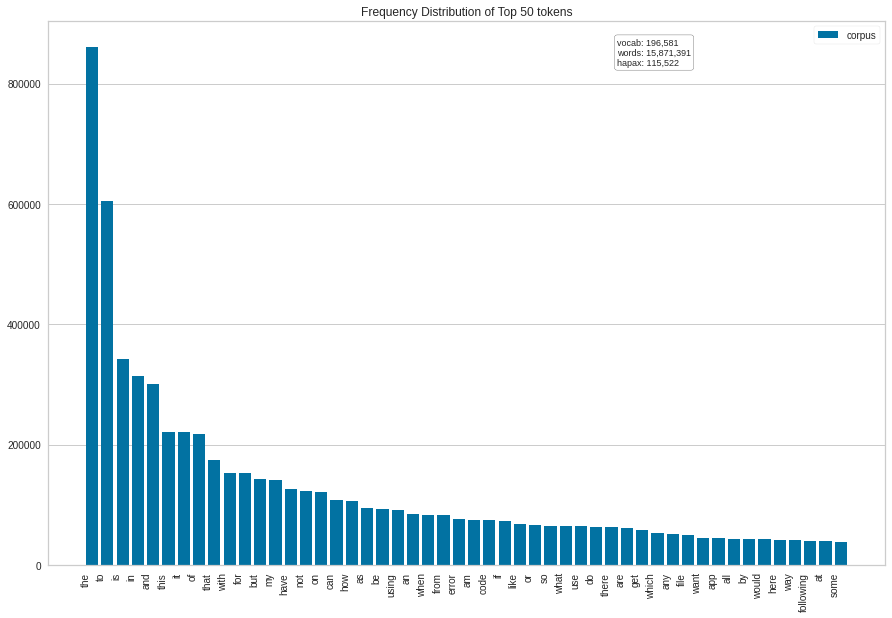

In [ ]:
visu_yellow(corpus_del_bal)

On voit qu'il y a toujours des mots redondants qui ne servent à rien à l'analyse.

### Nettoyage du texte (Suppression des fins de lignes et des chiffres) :

ici, nous supprimons les fins de lignes et les chiffres.

In [ ]:
%%time

def text_cleaning(text):
    text = re.sub('\w*\d\w*', '', text)  # supprimer tout les chiffres
    text = re.sub(r'\n', '', text)  # retirer les fins de lignes
    text = re.sub(r'\s+', ' ', text)  # retirer les fins de lignes de corpus
    # text = re.split("," , " ")
    return text


corpus_x = [text_cleaning(text) for text in corpus_del_bal]  # pour la liste
tags_x = [text_cleaning(text).strip() for text in tags]  # pour la liste
data['Corpus'] = data['Corpus'].apply(lambda x : text_cleaning(x))

CPU times: user 36.1 s, sys: 195 ms, total: 36.3 s
Wall time: 36.4 s


#### Visualisation :

In [ ]:
print('-'*45)
print("Visualisation du nettoyage texte sur le corpus :")
print('-'*45)
display(corpus_x[0])
print("")

print('-'*45)
print("Visualisation du nettoyage texte sur les tags :")
print('-'*45)
display(tags_x[0])
print("")

---------------------------------------------
Visualisation du nettoyage texte sur le corpus :
---------------------------------------------


'How can I construct my objects allocated through std::allocator::allocate()?C++ removed the and members from . How am I supposed to construct my objects allocated through ? I found and , but as far as I understood they are not allocator-aware, and they do copies, which I think would hurt performance a lot for non-POD types. '


---------------------------------------------
Visualisation du nettoyage texte sur les tags :
---------------------------------------------


'c++ std c++ allocator'

#### Visualisation Yellowbricks en token :

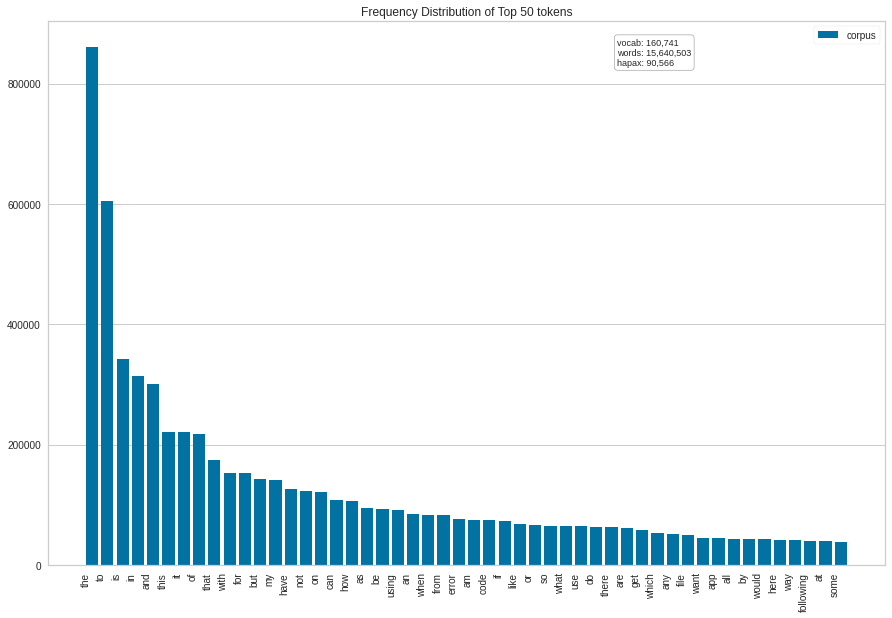

In [ ]:
visu_yellow(corpus_x)

Le corpus pré-nettoyé reste actuellement inutilisable.

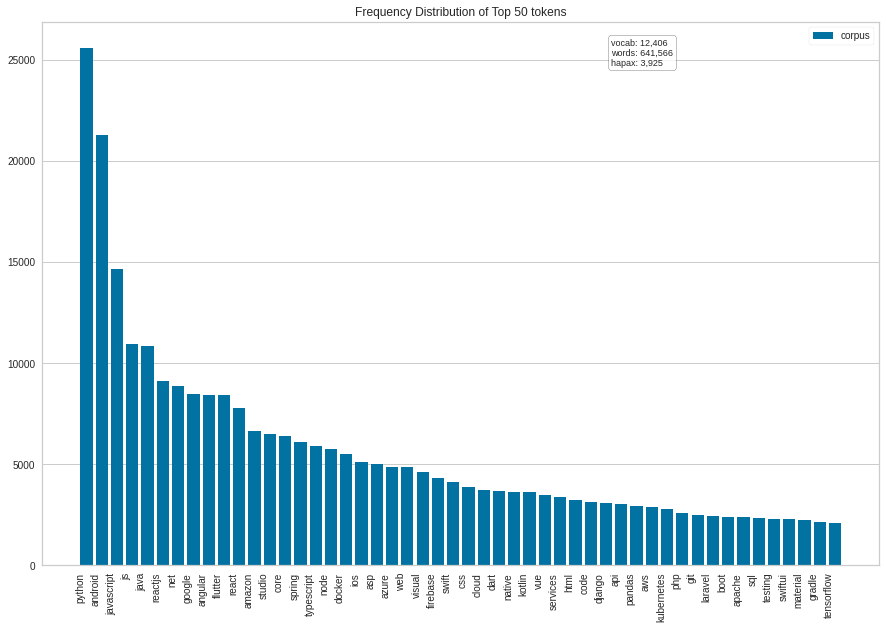

In [ ]:
visu_yellow(tags_x)

Ici, on peut voir que les Tags sont bien représentés.

### Suppression des verbes contractées :

Suppression des formes contractés des verbes.

In [ ]:
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):

    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
            if contraction_mapping.get(match)\
            else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [ ]:
%%time
corpus_x = [expand_contractions(text) for text in corpus_del_bal]
tags_x = [expand_contractions(text).strip() for text in tags]
# data['Corpus'] = data['Corpus'].apply(lambda x : expand_contractions(x))

CPU times: user 2min 52s, sys: 437 ms, total: 2min 52s
Wall time: 2min 52s


#### Visualisation 

In [ ]:
print('-'*60)
print("Visualisation de la suppression des verbes contractés sur le corpus :")
print('-'*60)
display(corpus_x[0])
print("")

print('-'*60)
print("Visualisation de la suppression des verbes contractés sur les tags :")
print('-'*60)
display(tags_x[0])
print("")

------------------------------------------------------------
Visualisation de la suppression des verbes contractés sur le corpus :
------------------------------------------------------------


'How can I construct my objects allocated through std::allocator::allocate()?C++20 removed the  and  members from . How am I supposed to construct my objects allocated through ? I found  and , but as far as I understood they are not allocator-aware, and they do copies, which I think would hurt performance a lot for non-POD types. '


------------------------------------------------------------
Visualisation de la suppression des verbes contractés sur les tags :
------------------------------------------------------------


'c++ std c++20 allocator'

#### Visualisation Yellowbricks en token :

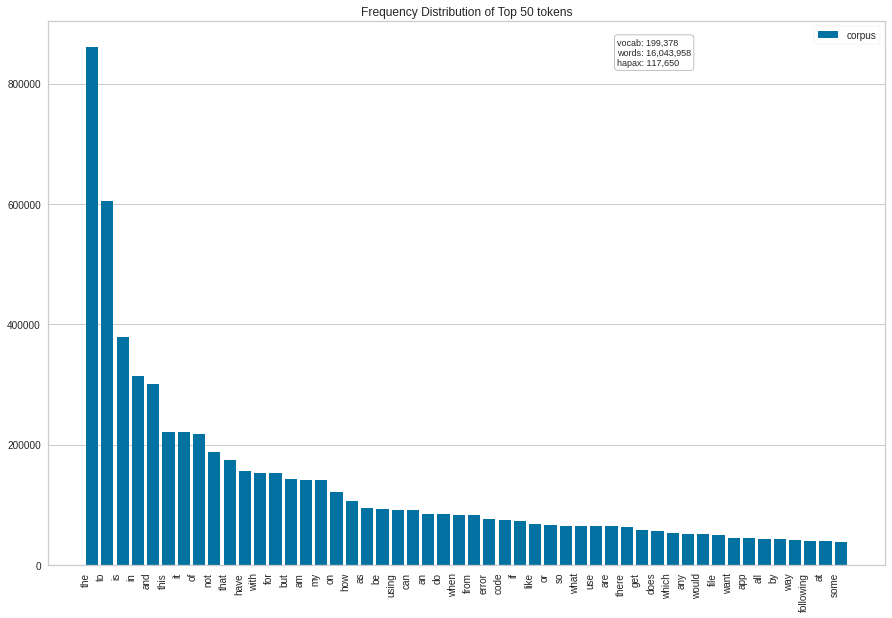

In [ ]:
visu_yellow(corpus_x)

Peu de difference ici, vu que les mots contractées ne doivent pas être dans le top 50.

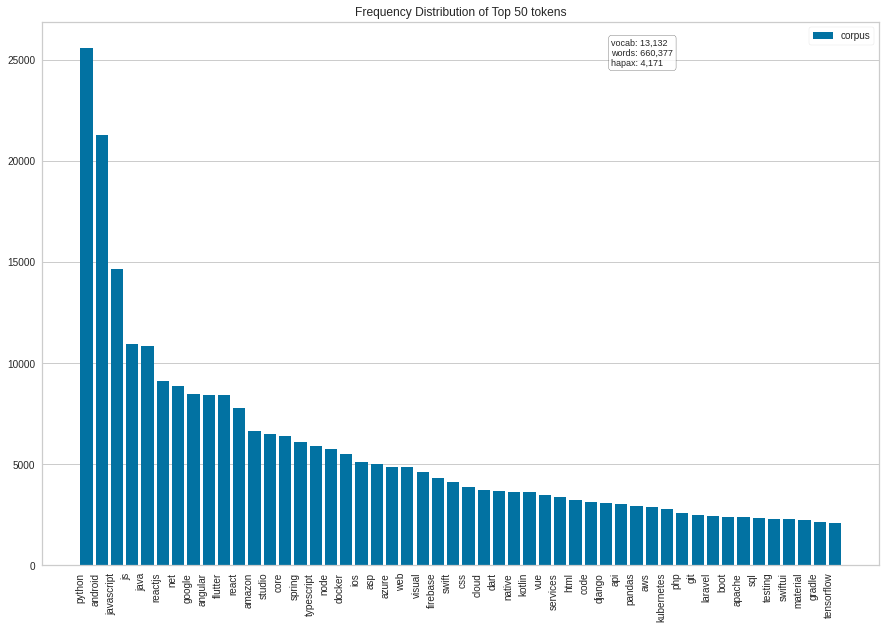

In [ ]:
visu_yellow(tags_x)

Idem les tags étant déjà des termes spécifiques, pas de raison de retrouver une difference entre les 2.

### Tokenization + suppression des stopwords :

La tokenisation consiste essentielleent à diviser une phrase, paragraphe ou un document de texte en unités plus petites, entant que mots ou termes individuels. On appelle ces mots des tokens d'ou tokenisation.

Un stopword est un mot qui est tellement commun qu'il est inutile de l'indexer ou de l'utiliser dans une recherche.

In [ ]:
import string  # permet d'avoir accés à toute les ponctuations.
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def tokenize(text):

    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)

    try:
        res = word_tokenize(text, language='english')
    except TypeError:
        return text

    res = [token for token in res if token not in punctuation]
    res = [token for token in res if token not in stop_words]
   # res = [token for token in res if token not in letters]
    return res

In [ ]:
%%time
corpus_token = [tokenize(text) for text in corpus_x]
tag_token = [tokenize(text) for text in tags_x]
# data['Corpus'] = data['Corpus'].apply(lambda x : tokenize(x))

CPU times: user 3min 17s, sys: 8.77 s, total: 3min 26s
Wall time: 3min 27s


#### Visualisation :

In [ ]:
print('-'*65)
print("Visualisation de la suppression de la tokennisation sur le corpus :")
print('-'*65)
display(corpus_token[0])
print("")

print('-'*65)
print("Visualisation de la suppression de la tokennisation sur les tags :")
print('-'*65)
display(tag_token[0])
print('')

-----------------------------------------------------------------
Visualisation de la suppression de la tokennisation sur le corpus :
-----------------------------------------------------------------


['How',
 'I',
 'construct',
 'objects',
 'allocated',
 'std',
 ':allocator',
 ':allocate',
 'C++20',
 'removed',
 'members',
 'How',
 'I',
 'supposed',
 'construct',
 'objects',
 'allocated',
 'I',
 'found',
 'far',
 'I',
 'understood',
 'allocator-aware',
 'copies',
 'I',
 'think',
 'would',
 'hurt',
 'performance',
 'lot',
 'non-POD',
 'types']


-----------------------------------------------------------------
Visualisation de la suppression de la tokennisation sur les tags :
-----------------------------------------------------------------


['c++', 'std', 'c++20', 'allocator']

###  POS tagging :

Parts of Speech (POS) Tagging. Parts of speech tagging simply refers to assigning parts of speech to individual words in a sentence, which means that, unlike phrase matching, which is performed at the sentence or multi-word level, parts of speech tagging is performed at the token level.

source : https://stackabuse.com/python-for-nlp-parts-of-speech-tagging-and-named-entity-recognition/

NN: noun, common, singular or mass

POS tagging Parts of Speech (POS) Tagging. Parts of speech tagging simply refers to assigning parts of speech to individual words in a sentence, which means that, unlike phrase matching, which is performed at the sentence or multi-word level, parts of speech tagging is performed at the token level.

NN: noun, common, singular or mass

source : https://stackabuse.com/python-for-nlp-parts-of-speech-tagging-and-named-entity-recognition/:

In [ ]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
def filtering_nouns(text):

    res = nltk.pos_tag(text)

    res = [token[0] for token in res if token[1] == 'NN']# Rajouter adverbe etc etc

    return res

In [ ]:
%%time
nn_corpus = [filtering_nouns(tokens) for tokens in corpus_token]

CPU times: user 10min 39s, sys: 4.63 s, total: 10min 43s
Wall time: 10min 45s


#### Visualisation :

In [ ]:
print('-'*65)
print("Visualisation du POS Tagging sur le corpus :")
print('-'*65)
display(nn_corpus[0])
print("")

-----------------------------------------------------------------
Visualisation du POS Tagging sur le corpus :
-----------------------------------------------------------------


[':allocator', 'construct', 'performance', 'lot']

### Lemmatisation

La lemmatisation désigne un traitement lexical apporté à un texte en vue de son classement dans un index ou de son analyse. Ce traitement consiste à appliquer aux occurrences des lexèmes sujets à flexion un codage renvoyant à leur entrée lexicale commune, que l'on désigne sous le terme de lemme.

source : Wikipedia

In [ ]:
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def lemmatisation(text):

    # Init the Wordnet Lemmatizer
    lemmatizer = WordNetLemmatizer()

    res = [lemmatizer.lemmatize(word, wordnet.VERB) for word in text]
    res = [lemmatizer.lemmatize(word, wordnet.ADJ) for word in res]
    res = [lemmatizer.lemmatize(word, wordnet.NOUN) for word in res]
    res = [lemmatizer.lemmatize(word, wordnet.ADV) for word in res]
    return res

In [ ]:
%%time
corpus_lem = [lemmatisation(tokens) for tokens in nn_corpus]
tags_lem = [lemmatisation(tokens) for tokens in tag_token]
# data['Corpus'] = data['Corpus'].apply(lambda x : lemmatisation(x))

tags_liste = []
for tokens in tags_lem:
    tokens = [token for token in tokens if len(token) > 1]
    tags_liste.append(tokens)

CPU times: user 43.6 s, sys: 504 ms, total: 44.1 s
Wall time: 44.2 s


#### Visualisation :

In [ ]:
print('-'*65)
print("Visualisation de la lemmatisation sur le corpus :")
print('-'*65)
display(corpus_lem[0])
print("")

print('-'*65)
print("Visualisation de la lemmatisation sur les Tags")
print('-'*65)
display(tags_lem[0])
print("")

-----------------------------------------------------------------
Visualisation de la lemmatisation sur le corpus :
-----------------------------------------------------------------


[':allocator', 'construct', 'performance', 'lot']


-----------------------------------------------------------------
Visualisation de la lemmatisation sur les Tags
-----------------------------------------------------------------


['c++', 'std', 'c++20', 'allocator']

# Features Engineering :

## Création des colonnes de preprocessing et création d'un nouveau DF :

In [ ]:
# remettre sous forme de phrase et non sous forme de liste
corpus_df = [" ".join(text) for text in corpus_lem]
# On crée un dataframe
corpus_df = pd.DataFrame(corpus_df, columns=['corpus_preprocessing'])

In [ ]:
corpus_df

,corpus_preprocessing
0,:allocator construct performance lot
1,cache route question anything site regeneratio...
2,field issue text scroll view line select text ...
3,closure path state localsI closure path state ...
4,statement consistency Chapter statement consis...
...,...
152261,date column dd/mm/yy hh mm hh mm ssI dataframe...
152262,iPhone version Xcode error device way
152263,start background task project start action sta...
152264,difference install question anything run machi...


In [ ]:
tags_df = [" ".join(tags) for tags in tags_liste]
tags_df = pd.DataFrame(tags_df, columns=['tags_preprocessing'])

In [ ]:
tags_df

,tags_preprocessing
0,c++ std c++20 allocator
1,typescript next.js contentful
2,textfield selection flutter-web
3,.net-core closure
4,java java-memory-model jls
...,...
152261,panda date datetime
152262,io iphone xcode
152263,android android-architecture-components androi...
152264,javascript node.js npm npm-install


In [ ]:
df_final = pd.concat([corpus_df, tags_df], axis=1)

In [ ]:
df_final['corpus_preprocessing'] = df_final['corpus_preprocessing'].apply(
    lambda x: x.split(' '))
df_final['tags_preprocessing'] = df_final['tags_preprocessing'].apply(
    lambda x: x.split(' '))

In [ ]:
corpus_final = df_final['corpus_preprocessing'].to_list()
tags_final = df_final['tags_preprocessing'].to_list()
data_corpus_base = data['Corpus'].to_list()

In [ ]:
df_visualisation = pd.concat([data['Corpus'],
                              data['Tags'],
                              df_final['corpus_preprocessing'],
                              df_final['tags_preprocessing']],
                             axis=1)

In [ ]:
display(df_visualisation.head())
# Ici on voit bien qu'on a nos tags modifiés et non modifiés,.
# on pourra supprimer les balises via regex par la suite pour les tags

,Corpus,Tags,corpus_preprocessing,tags_preprocessing
0,How can I construct my objects allocated throu...,c++ std c++20 allocator,"[:allocator, construct, performance, lot]","[c++, std, c++20, allocator]"
1,"How to clear NextJs GetStaticPaths cache / ""un...",typescript next.js contentful,"[cache, route, question, anything, site, regen...","[typescript, next.js, contentful]"
2,Flutter Web - Text field scrolls instead of se...,textfield selection flutter-web,"[field, issue, text, scroll, view, line, selec...","[textfield, selection, flutter-web]"
3,Avoid closure on fast path by storing state in...,c# .net-core closures,"[closure, path, state, localsI, closure, path,...","[.net-core, closure]"
4,Java Memory Model: a JLS statement about seque...,java java-memory-model jls,"[statement, consistency, Chapter, statement, c...","[java, java-memory-model, jls]"


Avant de calculer le bag of Word, le tf idf et le nmf, on va réduire le nombre de tags pour notre analyse.

## Comptage des Tags :

In [ ]:
df_visualisation["Tags_count"] = df_visualisation["Tags"].apply(lambda x : len(x.split()))
df_visualisation.head()

,Corpus,Tags,corpus_preprocessing,tags_preprocessing,Tags_count
0,How can I construct my objects allocated throu...,c++ std c++20 allocator,"[:allocator, construct, performance, lot]","[c++, std, c++20, allocator]",4
1,"How to clear NextJs GetStaticPaths cache / ""un...",typescript next.js contentful,"[cache, route, question, anything, site, regen...","[typescript, next.js, contentful]",3
2,Flutter Web - Text field scrolls instead of se...,textfield selection flutter-web,"[field, issue, text, scroll, view, line, selec...","[textfield, selection, flutter-web]",3
3,Avoid closure on fast path by storing state in...,c# .net-core closures,"[closure, path, state, localsI, closure, path,...","[.net-core, closure]",3
4,Java Memory Model: a JLS statement about seque...,java java-memory-model jls,"[statement, consistency, Chapter, statement, c...","[java, java-memory-model, jls]",3


In [ ]:
print( "Le nombre de Tags dans une question est au nombre de : ", '\033[1m'+ str(round(df_visualisation["Tags_count"].mean(),2)) + '\033[0m')

Le nombre de Tags dans une question est au nombre de :  3.19


# Enregistrer le dataframe dans un PICKLE :

In [ ]:
pd.to_pickle(df_visualisation, "/content/drive/My Drive/Colab Notebooks/TEST/p5_visualisation_part_1.pkl")